# Часть 1. Проверка гипотезы в Python и составление аналитической записки

## Сравнительный анализ среднего времени прослушивания книг пользователями Москвы и Санкт-Петербурга: проверка гипотезы в Python и составление аналитической записки.

- Автор: Ольга Агафонова
- Дата: 28.06.2025г.

## Цели и задачи проекта:

**Цель проекта** - проверка гипотезы о том, что пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Составление на основе проведенных исследований аналитической записки.

**Задачи проекта:**

* Загрузка данных и знакомство с ними.
* Проверка гипотезы с помощью проведения статистического теста.
* Составление аналитической записки.


## Описание данных

В работе будут использованы данные датасета `yandex_knigi_data.csv`, содержащий следующие поля:

- `city` - город пользователя;

- `puid` - идентификатор пользователя;

- `hours` - общее количество часов активности.

## Содержимое проекта

- Загрузка и обработка данных.
- Расчет и сравнение размеров выборок, их статистик и распределений.
- Определение типа статистического теста на основе полученных данных для корректной проверки гипотезы.
---

## 1. Загрузка данных и знакомство с ними

Загрузим данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `/datasets/yandex_knigi_data.csv`.

In [1]:
# Импортируем необходимые для анализа данных библиотеки и модули:
import pandas as pd

!pip install matplotlib_venn -q
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
import math

import warnings
warnings.simplefilter(action='ignore')

In [2]:
# Считаем и сохраним в датафрейм `knigi` датасет `yandex_knigi_data.csv`. 
# Выведем на экран первые строки полученного датафрейма.
knigi = pd.read_csv('https://code.s3.yandex.net/datasets/yandex_knigi_data.csv', index_col=0)
knigi.head()

,city,puid,hours
0,Москва,9668,26.167776
1,Москва,16598,82.111217
2,Москва,80401,4.656906
3,Москва,140205,1.840556
4,Москва,248755,151.326434


In [3]:
# Выведем основную информацию о датафрейме `knigi`.
knigi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8784 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    8784 non-null   object 
 1   puid    8784 non-null   int64  
 2   hours   8784 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 274.5+ KB


*Полученная информация показывает, что поля датафрейма не содержат пропусков, но необходимо проверить данные столбца `puid` на наличие дубликатов.*

In [4]:
# Посчитаем количество строк до удаления дубликатов с помощью метода shape[0] и результат сохраним 
# в переменную initial_row_count:
initial_row_count = knigi.shape[0]

# В переменной duplicat сохраним найденное количество дубликатов по данному столбцу:
duplicat = knigi.loc[knigi.duplicated(subset=['puid'], keep=False)].shape[0]

# Отсортируем датафрейм по всем столбцам:
sorted_df = knigi.sort_values(by=list(knigi.columns))

# Удалим дубликаты:
new_df = sorted_df.drop_duplicates(subset=['puid'])

# Выведем количество строк после удаления дубликатов:
final_df = new_df.shape[0]

# Результат выведем на экран:
print(f'Исходное количесвто строк: {initial_row_count}')
print(f'Количество найденных дубликатов: {duplicat}')
print(f'Количесвто строк после удаления дубликатов: {final_df}')

Исходное количесвто строк: 8784
Количество найденных дубликатов: 488
Количесвто строк после удаления дубликатов: 8540


***Далее, будем работать с датафреймом `new_df`.***

## 2. Проверка гипотезы в Python

*Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуем статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:*

- ***Нулевая гипотеза H₀:*** *Средняя время активности пользователей в часах в Санкт-Петербурге не больше, чем в Москве.*

- ***Альтернативная гипотеза H₁:*** *Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.*

In [5]:
# Разделим пользователей на две группы по городам:
moscow_users = new_df[new_df['city'] == 'Москва']['hours']
spb_users = new_df[new_df['city'] == 'Санкт-Петербург']['hours']

# Зададим уровень значимости: 
alpha = 0.05

# Выведем результат сравнения размеров групп:
print('\n--- Размер групп ---')
print(f'Москва: {len(moscow_users)} пользователей')
print(f'Санкт-Петербург: {len(spb_users)} пользователей')

# Выведем результат сравнения описательных статистик:
print('\n--- Описательные статистики ---')
print('Москва:')
print(moscow_users.describe())
print('Санкт-Петербург:')
print(spb_users.describe())


--- Размер групп ---
Москва: 6234 пользователей
Санкт-Петербург: 2306 пользователей

--- Описательные статистики ---
Москва:
count    6234.000000
mean       10.881092
std        36.851683
min         0.000018
25%         0.059903
50%         0.924498
75%         5.939972
max       857.209373
Name: hours, dtype: float64
Санкт-Петербург:
count    2306.000000
mean       11.264433
std        39.831755
min         0.000025
25%         0.060173
50%         0.875355
75%         6.138424
max       978.764775
Name: hours, dtype: float64


In [6]:
# Проверим, соответствуют ли выборки нормальному распределению. Для этого выполним тест Шапиро-Уилка. 
# Cформулируем гипотезы:
# - Н0: данные подчиняются нормальному распределению;
# - Н1: данные не подчиняются нормальному рапределению.

# Для не нормального распределения характерен непараметрический тест.
print('\n--- Проверка нормальности ---')
shapiro_moscow = stats.shapiro(moscow_users)
shapiro_spb = stats.shapiro(spb_users)
print(f'Москва: p-value = {shapiro_moscow.pvalue:.4f}', 
      'Нельзя отвергнуть Н0 (данные нормальны)' if shapiro_moscow.pvalue > alpha else 'Отвергаем Н0 (данные не нормальны)')
print(f'Cанкт_Петербург: p-value = {shapiro_spb.pvalue:.4f}', 
      'Нельзя отвергнуть Н0 (данные нормальны)' if shapiro_spb.pvalue > alpha else 'Отвергаем Н0 (данные не нормальны)')


--- Проверка нормальности ---
Москва: p-value = 0.0000 Отвергаем Н0 (данные не нормальны)
Cанкт_Петербург: p-value = 0.0000 Отвергаем Н0 (данные не нормальны)


In [7]:
# Проверим равенство выборочных дисперсий перед проведением t-теста с помощью теста Леване.
# Сформулируем гипотезы:
# - Н0: Дисперсии сравниваемых групп равны;
# - Н1: Дисперсии сравниваемых групп не равны.

print('\n--- Проверка равенства дисперсий ---')
levene_test = stats.levene(moscow_users, spb_users)
print(f'Тест Леване: p-value = {levene_test.pvalue:.4f}', 
      'Нельзя отвергнуть Н0 (дисперсии равны)' if levene_test.pvalue > alpha else 'Отвергаем Н0 (дисперсии разные)')


--- Проверка равенства дисперсий ---
Тест Леване: p-value = 0.6679 Нельзя отвергнуть Н0 (дисперсии равны)


*Исходя из полученных статистик, отметим, что группа пользователей из Москвы, пользующихся приложением, по количеству превышает в 2,7 раза группу из Санкт-Петербурга. Также, обратим внимание, что максимальное время прослушивания аудиокниги (или чтения книги в приложении) пользователем были зафиксированы в Санкт-Петербурге. Представим визуально распределение осовного количества времени, проведенного пользователями Москвы и Санкт-Петербурга в приложении.*

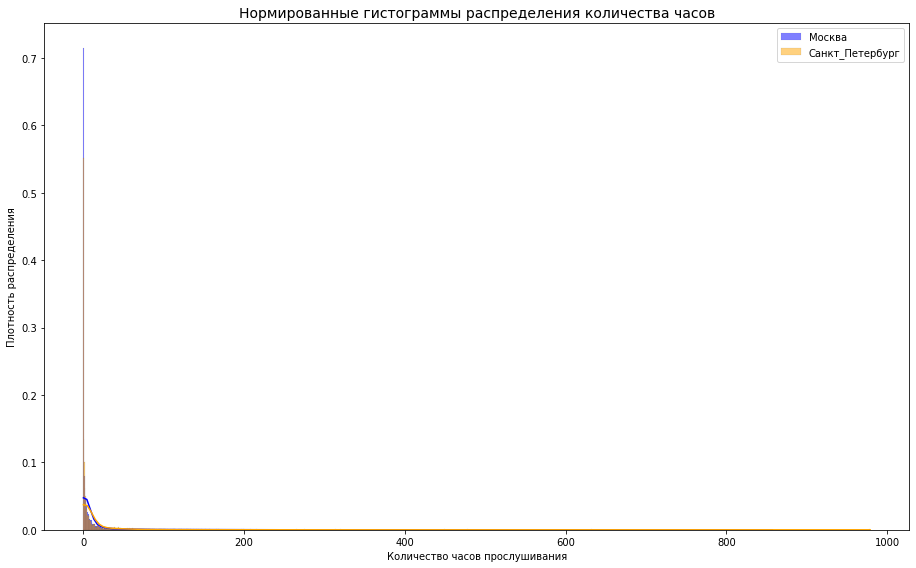

In [8]:
# Визуализацию распределения представим в виде гистограммы:
plt.figure(figsize=(25, 8))

plt.subplot(1, 2 ,1)
sns.histplot(data=moscow_users, color='blue', label='Москва', kde=True, stat='density', common_norm=False, alpha=0.5)
sns.histplot(data=spb_users, color='orange', label='Cанкт_Петербург', kde=True, stat='density', common_norm=False, alpha=0.5)
plt.title('Нормированные гистограммы распределения количества часов', fontsize=14)
plt.legend()
plt.xlabel('Количество часов прослушивания')
plt.ylabel('Плотность распределения')

# Определим лимит значений на осях для наглядности гистограммы, 
# т.к. основные значения расположены, примерно, в этих пределах:

plt.tight_layout()
plt.show()

*На гистограмме заметны значения по осям Х и Y, которые являются не типичными для основной группы значений и существенно их превышаютю. Вероятней всегоб это выбросы.*

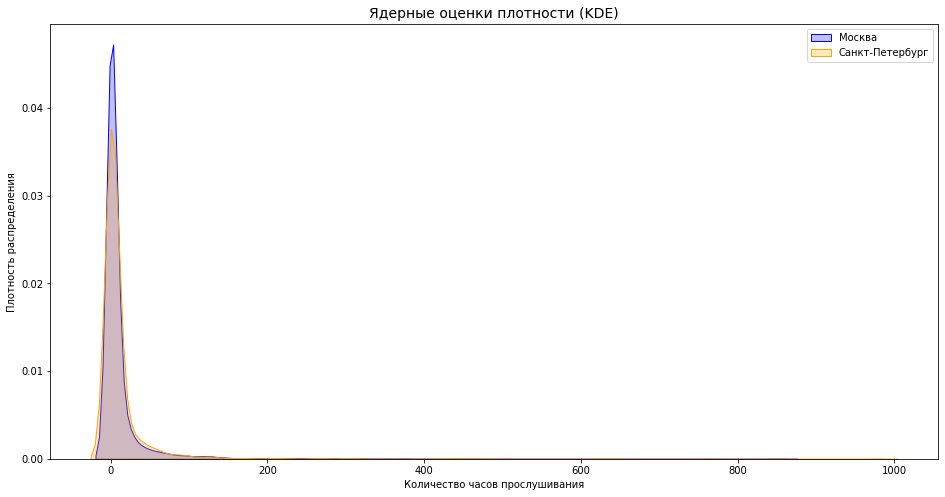

In [9]:
plt.figure(figsize=(35, 8))
plt.subplot(1, 2, 2)
sns.kdeplot(moscow_users, color='blue', label='Москва', fill=True)
sns.kdeplot(spb_users, color='orange', label='Санкт-Петербург', fill=True)
plt.title('Ядерные оценки плотности (KDE)', fontsize=14)
plt.xlabel('Количество часов прослушивания')
plt.ylabel('Плотность распределения')
plt.legend()

plt.show()

*На графике видно, что пользователи Москвы уделяли чтению и прослушиванию книг в приложение больше времени.*

***Исходя из полученного распределения количества часов на нормированной гистограмме, где явно прослеживаются аномальные значения, в дальнейшем исследовании будем использовать непараметрический тест - U-тест Манна-Уитни, так как он устойчив к выбросам.***

In [10]:
# Проведем двухвыборочный t-тест Манна-Уитни (односторонний: SPB > Moscow):
u_stat, p_value = stats.mannwhitneyu(spb_users, moscow_users, alternative='greater')

print('\nРезультат U-теста Манна-Уитни:')
print(f'U-статистика = {u_stat:.0f} - различия между значениями в группах несущественны, p-value = {p_value:.3f}')

# Выведем результат:
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: пользователи Санкт-Петербурга значимо больше времени проводят в приложении.')
else:
    print('Нет оснований отвергнуть нулевую гипотезу: различий нет или они не значимы.')


Результат U-теста Манна-Уитни:
U-статистика = 7157178 - различия между значениями в группах несущественны, p-value = 0.619
Нет оснований отвергнуть нулевую гипотезу: различий нет или они не значимы.


## 3. Аналитическая записка
По результатам анализа данных составим аналитическую записку, в которой зафиксируем основные моменты:

- По предварительным исследованиям определили, что в данном случае наиболее корректно использование U-теста Манна-Уитни при стандартном уровене статистической значимости alpha = 0.05.

- Полученное значение p-value = 0.619, а U-статистика Манна-Уитни = 7157178 - это значит, что значения групп пользователей Москвы и Санкт-Петербурга отличаются с минимальной разницей (возможно, пользователи Москвы имеют чуть более высокие значения, что видно на гистограмме).

- По результатам теста (p-value = 0.619 > 0.05 (alpha)) пришли к выводу о том, что нет оснований отвергать нулевую гипотезу - нет значимых отличий между средними активностями пользователей Москвы и Санкт-Петербурга.

- Причины, объясняющие полученные результаты анализа, возможно могут быть связаны с тем, что пользователи Москвы более платежеспособны, чем пользователи Санкт-Петербурга, исходя из условий, что подписка в приложении платная. Кроме того, можно предположить, что жители культурной столицы предпочитают пользоваться литературой в виде печатных изданий. Возможно, как следствием, может быть и зависимость от возрасной категории и, например, от числа жителей в этих городах (в Москве жителей более чем в два раза больше, чем в Санкт-Петербурге. И процент молодого поколения, предпочитающего прослушивание аудиокниг и чтение книг в электронном виде, соответственно, тоже выше.).



----

# Часть 2. Анализ результатов A/B-тестирования

## Оценка влияния оптимизации приложения BitMotion Kit на конверсию регистраций в покупки с помощью A/B-тестирования.

## 1. Формулировка цели исследования.



**Цель работы** - проведение A/B-теста, который позволит проверить гипотезу, что упрощение интерфейса онлайн-магазина BitMotion Kit приведёт к тому, что в течение семи дней после регистрации в системе конверсия зарегистрированных пользователей в покупателей увеличится как минимум на три процентных пункта. Анализ полученных результатов.

### Описание данных.

В проекте будут использованы данные из двух датасетов:

**`ab_test_participants.csv ` - таблица участников тестов. Содержит следующие поля:**

- `user_id` — идентификатор пользователя;
- `group` — группа пользователя;
- `ab_test` — название теста;
- `device` — устройство, с которого происходила регистрация.

**`ab_test_events.zip ` - архив с одним csv-файлом, в котором собраны события 2020 года. Структура файла:**

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Содержит числовые и текстовые значения.


## 2. Загрузка данных и оценка их целостности.


Загрузим данные и проведем их предобработку.

In [11]:
# Загрузим данные датасета `ab_test_participants.csv` и сохраним их в датафрейм `participants`:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')

# Загрузим архив датасета `ab_test_events.zip` и сохраним в датафрейм `events`:
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [12]:
# Выведем первые пять строк таблицы `participants` и основную информацию о ней:
participants.head()

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


In [13]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


*В столбцах датафрейма нет пропущенных значений. Проанализируем данные таблицы на наличие дублиткатов.*

In [14]:
# Отсортируем все столбцы датафрейма:
participants_sorted = participants.sort_values(by=list(participants.columns))

# Определим дубликаты в датафрейме `participants` и выведем их количество
duplicates = participants_sorted[participants_sorted.duplicated()].shape[0]
print(duplicates)

0


Дублирующие значения в датафрейме `participants` отсутствуют. Рассмотрим датафрейм `events`.

In [15]:
# Выведем первые 30 строк (для детального анализа содержимого столбцов) датафрейма `events` и основную информацию о его данных:
events.head(30)

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN
5,AA346F4D22148024,2020-12-01 00:01:46,registration,-2.0
6,7EF01D0E72AF449D,2020-12-01 00:02:06,registration,-5.0
7,9A6276AD14B14252,2020-12-01 00:02:20,registration,-2.0
8,9B186A3B1A995D36,2020-12-01 00:02:37,registration,-3.5
9,9A6276AD14B14252,2020-12-01 00:02:53,login,NaN


In [16]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


*Видно, что столбец `details` содержит пропуски. Изучим данные столбца детальнее. Столбец `details` имеет тип данных 'object', он содержит и числовые, и текстовые значения, в которых находится дополнительная информация о событии, например, указана стоимость покупки или стоимость привлечения клиента, а также код и зона события. Не всем пользователям присущи все типы событий, и этот фактор объясняет наличие пропусков в столбце. Учитывая, что столбец содержит дополнительную информацию в таблице и его данные не так значимы, то есть, особо не повлияют на анализ, считаю, что пропуски здесь можно не удалять и не заменять, а оставить как есть.*

In [17]:
# Посчитаем количество строк до удаления дубликатов с помощью метода shape[0] и результат сохраним 
# в переменную initial_row_count:
initial_row_count = events.shape[0]

# Отсортируем датафрейм по всем столбцам:
events_sorted = events.sort_values(by=list(events.columns))

# Определим количество дубликатов методом duplicated():
duplicatess = events_sorted[events_sorted.duplicated()].shape[0]

# Проведем удаление дубликатов в переменной events_no_duplicates с помощью метода drop_duplicates():
events_no_dupl = events_sorted.drop_duplicates()

# Сохраним количество строк после удаления дубликатов в переменной final_row_count:
final_row_count = events_no_dupl.shape[0]

# Выведем результат:
print(f'Количество строк до удаления дубликатов:{initial_row_count}')
print(f'Количество найденных дубликатов:{duplicatess}')
print(f'Количество строк после удаления дубликатов:{final_row_count}')

Количество строк до удаления дубликатов:787286
Количество найденных дубликатов:36318
Количество строк после удаления дубликатов:750968


***Далее в работе будем использовать данные датафрейма `events_no_dupl`.***

## 3. Оценка корректности проведения теста по таблице `ab_test_participants`:

   3\.1 Выделим пользователей, участвующих в тесте, и проверим:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [18]:
# Выделим пользователей, учавствующих в тесте 'interface_eu_test':
test_users = participants[participants['ab_test'] == 'interface_eu_test'].copy()

print(f'Всего пользователей в тесте interface_eu_test: {len(test_users)}')
print(f'Доля от общего числа пользователей: {len(test_users)/len(participants):.1%}')

Всего пользователей в тесте interface_eu_test: 10850
Доля от общего числа пользователей: 74.7%


Проверим данные на соответствие ТЗ и на нормальность распределения пользователей по группам: должно быть две группы А и В c, примерно, одинаковым количеством наблюдений. Пользователи в группах не должны пересекаться.

In [19]:
# Сохраним в переменной 'uniq_users' количество уникальных пользователей в группах А и В, участвующих в тесте:
uniq_users = test_users.groupby('group')['user_id'].nunique()
print(uniq_users)

group
A    5383
B    5467
Name: user_id, dtype: int64


In [20]:
# Выведем разницу в количестве пользователей между группами в относительном значении:
A = uniq_users['A']
B = uniq_users['B']

perc_diff = 100 * abs(A - B) / A
print(f'Процентная разница между группами А и В: {perc_diff:.2f}%')

Процентная разница между группами А и В: 1.56%


*Видно, что групп всего две: А (контрольная) и В (тестовая) и они равномерны по числу наблюдений с незначительной разницей всего в 1.56%.*

Проверим пересечение пользователей (определим количество пользователей, которые встречаются одновременно в группах A и B) и убедимся, что группы независимы. 

In [21]:
# Выведем группы А и В в виде множеств, используя функцию set():
group_A = set(test_users[test_users['group'] == 'A']['user_id'])
group_B = set(test_users[test_users['group'] == 'B']['user_id'])

# Определим пересечение пользователей (одновременное присутствие пользователей в группе А и В):
dubll_users = group_A & group_B

# Результат:
if not dubll_users:
    print('Группы А и В полностью независимы - пересечений нет')
else:
    print(f'Обнаружено {len(dubll_users)} пересекающихся пользователей: {dubll_users}')

Группы А и В полностью независимы - пересечений нет


Представим визуально результат пересечений с помощью диаграммы Венна.

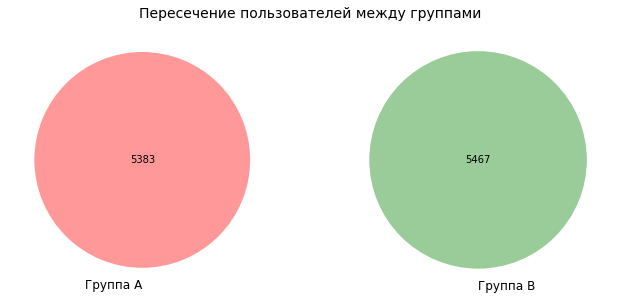

In [22]:
# Зададим параметры визуализации:
plt.figure(figsize=(12, 5))
venn2([group_A, group_B], ('Группа А', 'Группа В'))
plt.title('Пересечение пользователей между группами', fontsize=14)
plt.show()

***Расчет и график подтверждают, что группы А и В независимы.***

Проанализируем отсутствие пересечений с конкурирующим тестом 'recommender_system_test' (нет пользователей, участвующих одновременно в двух тестовых группах).

In [23]:
# Отфильтруем датафрейм по типу теста и группы В, сохраним полученные множества, используя функцию set():
test_recom = set(participants[(participants['ab_test'] == 'recommender_system_test') & 
                              (participants['group'] == 'B')]['user_id'])
test_inter = set(participants[(participants['ab_test'] == 'interface_eu_test') & 
                              (participants['group'] == 'B')]['user_id'])

# Определим пересечение пользователей (одновременное присутствие в двух тестовых группах и в двух эспериментах):
dubly_users = test_recom & test_inter

# Результат:
if not dubly_users:
    print('Тестовые группы по двум экспериментам полностью независимы - пересечений нет')
else:
    print(f'Обнаружено {len(dubly_users)} пересекающихся пользователей.')

Обнаружено 116 пересекающихся пользователей.


Визуализируем результат пересечения пользователей двух тестовых групп с помощью диаграммы Венна.

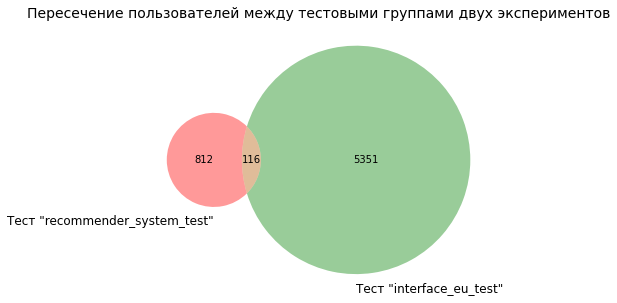

In [24]:
# Зададим параметры визуализации:
plt.figure(figsize=(12, 5))
venn2([test_recom, test_inter], ('Тест "recommender_system_test"', 'Тест "interface_eu_test"'))
plt.title('Пересечение пользователей между тестовыми группами двух экспериментов', fontsize=14)
plt.show()

***По полученным результатам видно, что есть 116 пользователей, которые попали в тестовые группы В обоих  экспериментов. Естественно, это нарушение проведения независимости тестов, результаты которых будут статистически некорректными. Процент "пересекающихся" пользователей составляет 1% от общего числа пользователей в тесте "interface_eu_test", поэтому удаление таких пользователей особо не повлияет на размер выборки группы В в  эксперименте "interface_eu_test".***

In [25]:
# Удалим "пересекающихся" пользователей в тестовой группе "interface_eu_test":
clean_df = test_users[~test_users['user_id'].isin(dubly_users)]
print(f'Осталось пользователей: {len(clean_df)}')

Осталось пользователей: 10734


In [26]:
# Проверим распределение количества уникальных пользователей в группах А и В, участвующих в тесте "interface_eu_test":
clean_users = clean_df.groupby('group')['user_id'].nunique()
print(clean_users)

group
A    5383
B    5351
Name: user_id, dtype: int64


In [27]:
# Выведем процентную разницу в количестве пользователей между группами:
A = clean_users['A']
B = clean_users['B']

с_perc_diff = 100 * abs(A - B) / A
print(f'Процентная разница между группами А и В: {с_perc_diff:.2f}%')

Процентная разница между группами А и В: 0.59%


***Видно, что удаление "пересекающихся" пользователей в тестовой группе "interface_eu_test" не повлияло на равномерность распределения значений в группах А и В. Разница в размерах выборок не значима - 1.19%.***

3\.2 Проанализируем данные о пользовательской активности по таблице `ab_test_events`:

- оставим только события, связанные с участвующими в изучаемом тесте пользователями;

Для получения необходимых данных объединим таблицы `clean_df` (уже содержит информацию об уникальных "непересекающихся" пользователях из тестовой группы "interface_eu_test") и `events_no_dupl` (датафрейм `events` без дубликатов).

In [28]:
# Для получения необходимых данных объединим таблицы :
total_df = pd.merge(clean_df, events_no_dupl, on='user_id')
display(total_df)

,user_id,group,ab_test,device,event_dt,event_name,details
0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:31,registration,-2.38
1,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:49,login,NaN
2,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:57,login,NaN
3,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:38:54,login,NaN
4,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-08 22:15:35,login,NaN
...,...,...,...,...,...,...,...
72930,FFEFC0E55C1CCD4F,A,interface_eu_test,PC,2020-12-13 23:52:22,login,NaN
72931,FFEFC0E55C1CCD4F,A,interface_eu_test,PC,2020-12-28 00:29:10,login,NaN
72932,FFF58BC33966EB51,A,interface_eu_test,Android,2020-12-13 17:37:34,registration,-0.45
72933,FFF58BC33966EB51,A,interface_eu_test,Android,2020-12-13 17:56:02,login,NaN


In [29]:
# Получим список уникальных пользователей, участвующих в тесте "interface_eu_test":
ev_inter_us = total_df[total_df['ab_test'] == 'interface_eu_test']['user_id'].unique()

# Отфильтруем полученные данные, оставляя только события этих пользователей:
inter_event = total_df[total_df['user_id'].isin(ev_inter_us)].copy()

# Проверим:
print(f'Всего событий в тестовой группе "interface_eu_test": {len(total_df)}')
print(f'Количество событий пользователей теста: {len(inter_event)}')
print(f'Уникальных пользователей в тесте: {len(ev_inter_us)}')

Всего событий в тестовой группе "interface_eu_test": 72935
Количество событий пользователей теста: 72935
Уникальных пользователей в тесте: 10734


In [30]:
# Распределим события по типам:
type_events = inter_event['event_name'].value_counts().reset_index()
type_events.columns = ['event_name', 'count']
type_events['perc'] = round(((type_events['count'] / len(inter_event)) * 100), 2)
print('\nРаспределение событий по типам:')
print(type_events)


Распределение событий по типам:
     event_name  count   perc
0         login  25902  35.51
1  product_page  17508  24.00
2  registration  10734  14.72
3      purchase   9527  13.06
4  product_cart   9264  12.70


Представим визуально активность пользователей относительно событий.

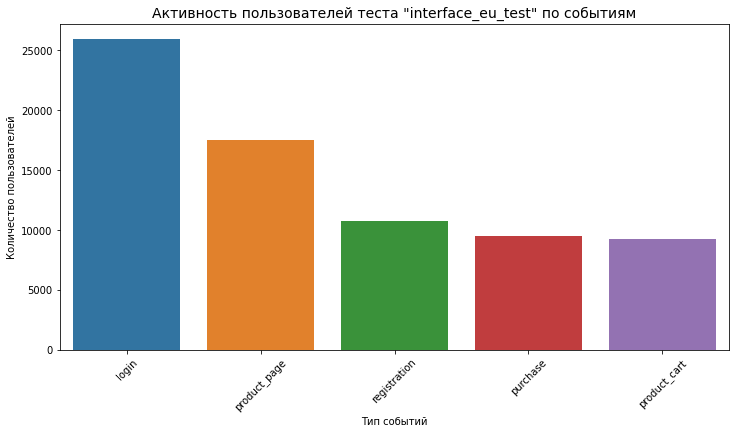

In [31]:
# Построим столбчатую диаграмму:
plt.figure(figsize=(12, 6))

sns.barplot(data=type_events, x='event_name', y='count')
plt.title('Активность пользователей теста "interface_eu_test" по событиям', fontsize=14)
plt.xlabel('Тип событий')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45)
plt.show()

***На графике и по расчетам видно, что лидирующие позиции занимают авторизирующиеся пользователи в количестве 25902 и пользователи, переходящие на страницу продукта - 17508.***

- определим горизонт анализа: рассчитаем время (лайфтайм) совершения события пользователем после регистрации и оставим только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [32]:
# Определим время регистрации для каждого пользователя:
registr_time = total_df[total_df['event_name'] == 'registration'].groupby('user_id')['event_dt'].first()

# Объединим полученную таблицу 'registr_time' с основным датафреймом и 
# выведем время регистрации для каждого события в новом столбце 'registration_time':
total_df = total_df.merge(registr_time.rename('registration_time'), on='user_id')

In [33]:
# Вычислим разницу между временем события и временем регистрации:
total_df['days_since_registr'] = ((total_df['event_dt'] - total_df['registration_time']).dt.total_seconds() / 
                                   (24 * 3600)).round().astype(int)

# Оставим только события, которые произошли в течение 7 дней после регистрации:
filtr_events = total_df[total_df['days_since_registr'] <= 7]


display(filtr_events)

,user_id,group,ab_test,device,event_dt,event_name,details,registration_time,days_since_registr
0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:31,registration,-2.38,2020-12-07 04:37:31,0
1,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:49,login,NaN,2020-12-07 04:37:31,0
2,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:57,login,NaN,2020-12-07 04:37:31,0
3,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:38:54,login,NaN,2020-12-07 04:37:31,0
4,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-08 22:15:35,login,NaN,2020-12-07 04:37:31,2
...,...,...,...,...,...,...,...,...,...
72929,FFEFC0E55C1CCD4F,A,interface_eu_test,PC,2020-12-13 23:52:15,registration,0.0,2020-12-13 23:52:15,0
72930,FFEFC0E55C1CCD4F,A,interface_eu_test,PC,2020-12-13 23:52:22,login,NaN,2020-12-13 23:52:15,0
72932,FFF58BC33966EB51,A,interface_eu_test,Android,2020-12-13 17:37:34,registration,-0.45,2020-12-13 17:37:34,0
72933,FFF58BC33966EB51,A,interface_eu_test,Android,2020-12-13 17:56:02,login,NaN,2020-12-13 17:37:34,0


Оценим достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%,

- ожидаемый показатель конверсии. - 33% (прогнозируемый прирост на 3 п.п.)

In [34]:
# Зададим параметры:

alpha = 0.05 # Уровень значимости при достоверности теста 95%
power = 0.8 # Мощность теста
p = 0.3 # Базовый уровень конверсии (30%)
mde = -0.03 # Минимальный детектируемый эффект (при выбранном относительном MDE = 3%)

# Зададим функцию, которая расчитает необходимый размер выборки:
def calculate_sample_size(p, mde, alpha, power):
    p1 = p + mde # конверсия в экспериментальной группе
    effect_size = proportion_effectsize(p, p1) # расчет размера эффекта
    
    # Инициализируем класс NormalIndPower:
    power_analysis = NormalIndPower()

    # Рассчитаем размер выборки:
    sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1, # равномерное распределение выборок
    alternative='larger'
    ) 
    return math.ceil(sample_size)

In [35]:
req_sample_size = calculate_sample_size(p, mde, alpha, power)



print(f"Необходимый размер выборки для каждой группы: {int(req_sample_size)}")
print(f'Ожидаемая конверсия в экспериментальной группе В: {(p+mde)*100:.2f}%')

Необходимый размер выборки для каждой группы: 2798
Ожидаемая конверсия в экспериментальной группе В: 27.00%


In [36]:
# Сравним фактический и требуемый размеры выборок.
# Выведем фиктический размер групп:
group_a_count = len(clean_df[clean_df['group'] == 'A'])
group_b_count = len(clean_df[clean_df['group'] == 'B'])

# Вывод результатов сравнения:
print('\n--- Сравнение размеров выборок ---')
print(f'Требуемый размер на группу: {req_sample_size}')
print(f'Группа А: {group_a_count} пользователей ({group_a_count/req_sample_size:.1%} от требуемого)')
print(f'Группа В: {group_b_count} пользователей ({group_b_count/req_sample_size:.1%} от требуемого)')

if min(group_a_count, group_b_count) < req_sample_size:
    print('\nТест может быть недостаточно мощным!')
else:
    print('\nРазмеры выборок достаточны для проведения теста!')



--- Сравнение размеров выборок ---
Требуемый размер на группу: 2798
Группа А: 5383 пользователей (192.4% от требуемого)
Группа В: 5351 пользователей (191.2% от требуемого)

Размеры выборок достаточны для проведения теста!


- рассчитаем для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

**Рассмотрим пользовательскую активность в первые семь дней после регистрации и изучим конверсию зарегистрированных пользователей  в покупатели за первые семь дней после регистрации. Результат сохраним в датафрейм `result_7`.**

In [37]:
# Рассчитаем общее количество посетителей в каждой группе:
total_visit = filtr_events.groupby('group')['user_id'].nunique().reset_index()
total_visit.columns = ['group', 'total_visit']

# Рассчитаем количество посетителей, совершивших покупку в первые семь дней с момента регистрации:
purch_visit = filtr_events[filtr_events['event_name'] == 'purchase'].groupby('group')['user_id'].nunique().reset_index()
purch_visit.columns = ['group', 'purch_visit']

# Объединим полученные результаты:
result_7 = pd.merge(total_visit, purch_visit, on='group', how='left').fillna(0)

# Определим конверсию зарегистрированных пользователей  в покупатели за первые семь дней после регистрации:
result_7['conversion_rate'] = result_7['purch_visit'] / result_7['total_visit']

print('Результаты по группам:')
display(result_7)

Результаты по группам:


,group,total_visit,purch_visit,conversion_rate
0,A,5383,1517,0.281813
1,B,5351,1625,0.303682


In [38]:
# Выведем данные с помощью таблицы pivot_table(), которую сохраним в переменную 'data':
data = filtr_events[filtr_events['event_name'].isin(['purchase', 'registration'])].pivot_table(index='group',
                                                                    columns='event_name',
                                                                    values='user_id',
                                                                    aggfunc='nunique')
# Добавим в таблицу столбец с расчетом конверсии:
data['conversion_rate'] = data['purchase'] / data['registration']

# Результат:
print(data)

event_name  purchase  registration  conversion_rate
group                                              
A               1517          5383         0.281813
B               1625          5351         0.303682


- сделаем предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.

In [39]:
# Рассчитаем разницу конверсий между группами в процентных пунктах для датафрейма 'result_7':
diff_pp_7 = (result_7.loc[result_7['group'] == 'B', 'conversion_rate'].values[0] -
           result_7.loc[result_7['group'] == 'A', 'conversion_rate'].values[0]) * 100

print(f'Разница между группами: {diff_pp_7:.1f} п.п.')

Разница между группами: 2.2 п.п.


*По полученным результатам видно, что за семь дней эксперимента конверсия посетителей в покупатели в тестовой группе по сравнению с контрольной увеличилась на 2.2 процентных пункта, что не соответствует запланированному приросту в 3 п.п.. Эффект от изменений есть, но он недостаточно высокий.*

## 4. Проведение оценки результатов A/B-тестирования:

- Проверим изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

Используя Z-тест пропорций для проверки односторонней альтернативной гипотезы, рассчитаем, является ли изменение в метрике конверсия пользователей в покупатели статистически значимым.
Выведим на экран полученные значения Z-статистики и p-value, а также выводы о статистической значимости, учитывая, что уровень значимости в эксперименте был выбран на уровне 0.05. При проведении теста, будем пользоваться данными датафрейма `result_7`. Нам важно статистически подтвердить изменение конверсии именно за семь дней в тестовой группе. Сформулируем гипотезы:

- Нулевая гипотеза Н0: Конверсия в группе В меньше или равна конверсии в группе А.
- Альтернативная гипотеза Н1: Конверсия в группе В значимо выше, чем в группе А.

In [40]:
# Посчитаем количество покупателей (пользователи, совершившие покупки) и 
# общее число наблюдений в каждой группе (размер выборки):
success_A = result_7[result_7['group'] == 'A']['purch_visit'].values[0]
total_A = result_7[result_7['group'] == 'A']['total_visit'].values[0]

success_B = result_7[result_7['group'] == 'B']['purch_visit'].values[0]
total_B = result_7[result_7['group'] == 'B']['total_visit'].values[0]

alpha = 0.05

# Проведем Z-тест для пропорций:
z_stat, p_value = proportions_ztest(count=[success_B, success_A],
                                   nobs=[total_B, total_A], alternative='larger')

In [41]:
# Выведем результат:
print(f'Z-статистика: {z_stat:.2f}')
print(f'p-value: {p_value:.4f}')

# Проверим статистическую значимость:
if p_value < alpha:
    print('Отвергаем Н0: конверсия в группе В значимо выше (р < 0.05).')
else:
    print('Не отвергаем Н0: не достаточно доказательств роста конверсии.')

Z-статистика: 2.49
p-value: 0.0064
Отвергаем Н0: конверсия в группе В значимо выше (р < 0.05).


- Опишем выводы по проведённой оценке результатов A/B-тестирования. Интерпретируем результаты A/B-тестирования. Обозначим, был ли достигнут ожидаемый эффект в изменении конверсии.

**На основе проведённого анализа результатов А/В-теста сделаем следующие выводы:**

- В ходе проведения эксперимента была изучена ключевая метрика продукта: конверсия зарегистрированных пользователей в покупатели за семь дней с момента регистрации. 

- Перед проведением статистического теста оценили достаточность размера выборки  - 10 пользователей, тем самым убедились в полноразмерности выборок для более точного проведения эксперимента.

- На начальном этапе эксперимента группы А и В были проверены на независимость и уникальность данных (отсутствие пересечения пользователей и участие пользователей тестовой группы только в эксперименте 'interface_eu_test') и на совпадение групп по числу пользователей  (разница не существенна -  1.19%).

- Определили, что по типам событий больше всего авторизирующихся пользователей (25902) и пользователей, переходящих на страницу товара (17508).

- Основные условия для корректного проведения А/В-тестирования были соблюдены. 

- В результате проведенного Z-теста для сравнения пропорций с односторонней альтернативной гипотезой по итогам эксперимента было выявленно, что конверсия за семь дней эксперимента в тестовой группе (группа В) на 1.9 процентных пункта стала выше, чем в контрольной (группа А), что не соответствуем ожидаемым результатам (увеличение конверсии за семь дней на 3 п.п.). Следовательно, упрощение интерфейса итернет-магазина BitMotion Kit положительно повлияло на рост целевой метрики.

- Статистическая значимость выявленного эффекта оценивается значением p-value, равным 0.0064, которое меньше заданного уровня значимости 0.05, а также положительным значением Z-статистики 2.49, которое указывает на рост конверсии в группе В по сравнению с группой А. Таким образом, нулевая гипотеза не находит подтверждения. 

- Анализ результатов эксперимента подтверждает альтернативную гипотезу и стаистически доказывает, что обновленная версия сайта онлайн-магазина удобна пользователям, тем самым увеличивая их интерес к товарам онлайн-магазина, а следовательно, и к совершению покупок.